In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import calibration as cal
import ATC as atc
import numpy as np
from scipy.special import softmax
import pandas as pd
import os.path
import os

In [3]:
#read source probs and source labels
source_probs_fp = "./results/cifar-10-densenet_cifar-10_preds.csv"
source_labels_fp = "./results/cifar-10_labels.csv"

source_probs_df = pd.read_csv(source_probs_fp, header=None)
source_probs = softmax(source_probs_df.to_numpy(), axis = 1)

source_labels_df = pd.read_csv(source_labels_fp, header=None)
source_labels = source_labels_df.to_numpy().reshape(-1)

In [20]:
#print(source_probs.shape)
#print(source_labels.shape)

(10000, 10)
(10000,)


In [4]:
#train calibrator on source validation set
calibration_error = cal.ece_loss(source_probs, source_labels)
print("Calibration error is {}".format(calibration_error))
calibrator = cal.TempScaling(bias=False)
calibrator.fit(source_probs, source_labels)

Calibration error is 0.026556584569866856


In [5]:
#calibrate source probs
calibrated_source_probs = calibrator.calibrate(source_probs)

In [19]:
#read test probs and test labels
test_probs_fp = "./results/cf10-densenet_cf10c-motion_preds.csv"
test_probs_df = pd.read_csv(test_probs_fp, header=None)
test_probs = softmax(test_probs_df.to_numpy(), axis = 1)

test_labels_fp = "./results/cf10c-motion_labels.csv"
test_labels_df = pd.read_csv(test_labels_fp, header=None)
test_labels = test_labels_df.to_numpy().reshape(-1)
#print(test_labels.shape)

(50000,)


In [16]:
# calibrate test probs
calibrated_test_probs = calibrator.calibrate(test_probs)
#print(np.sum(calibrated_test_probs != test_probs))

In [18]:
# helper function for calculating accuracy 
def acc (model_probs, labels):
    preds = np.argmax(model_probs, axis=-1)
    accuracy = np.mean(preds == labels)*100.0
    return accuracy 

In [24]:
class_num = 10
results = np.zeros((class_num,6))

for i in range(class_num):
    group_label = i

    #source group accuracy 
    source_group_probs = calibrated_source_probs[source_labels == i]
    source_group_acc = acc(source_group_probs, group_label)
    results[i][0] = source_group_acc

    #test group accuracy 
    test_group_probs = calibrated_test_probs[test_labels == i]
    test_group_acc = acc(test_group_probs, group_label)
    results[i][1] = test_group_acc

    #group atc estimation using unified threshold obtained from the entire source val set
    group_atc, threshold_a = atc.ATC_accuracy(calibrated_source_probs, source_labels, test_group_probs)
    results[i][2] = group_atc
    results[i][3] = threshold_a

    #group atc estimation using group-specific thresholds obtained from individual groups in the source val set
    source_group_labels = np.ones(len(source_group_probs)) * group_label
    group_atc_spec, threshold_g = atc.ATC_accuracy(source_group_probs, source_group_labels, test_group_probs)
    results[i][4] = group_atc_spec
    results[i][5] = threshold_g


In [25]:
print(results)

[[92.1        73.72       76.28        0.7119903  78.06        0.68728709]
 [95.5        72.84       73.4         0.7119903  66.4         0.79227519]
 [89.1        73.98       78.7         0.7119903  79.44        0.70189333]
 [82.6        85.28       83.24        0.7119903  81.2         0.7358309 ]
 [94.2        65.86       71.32        0.7119903  73.82        0.68493152]
 [88.8        63.84       76.9         0.7119903  74.26        0.74205005]
 [95.         39.62       64.42        0.7119903  70.86        0.65012485]
 [94.4        58.62       67.22        0.7119903  68.72        0.69310904]
 [96.4        75.42       79.68        0.7119903  78.5         0.72884518]
 [96.5        49.76       65.14        0.7119903  65.94        0.70499134]]


In [26]:
r_df = pd.DataFrame(results)
r_df.to_csv("./results/cf10c-motion.csv", index=True, header=['ID_acc', 'OOD_acc', 'atc','atc_ts', 'atc_g', 'atc_g_ts'])

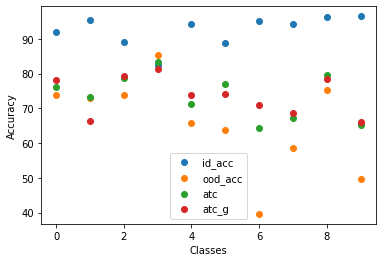

In [28]:
# import matplotlib.pyplot as plt

# x = np.arange(class_num)

# id_acc = results[:,0]
# ood_acc = results[:,1]
# atc = results[:,2]
# atc_g = results[:,4]

# plt.scatter(x, id_acc, label="id_acc")
# plt.scatter(x, ood_acc, label="ood_acc")
# plt.scatter(x, atc, label="atc")
# plt.scatter(x, atc_g, label="atc_g")

# plt.legend(loc="lower center")
# plt.xlabel("Classes")
# plt.ylabel("Accuracy")

# plt.show()

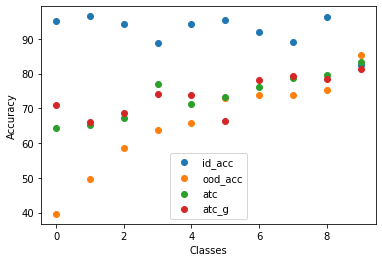

In [30]:
ood_acc = results[:,1]
x = np.argsort(ood_acc)

id_acc = results[x,0]
ood_acc = results[x,1]
atc = results[x,2]
atc_g = results[x,4]

x = np.arange(class_num)

plt.scatter(x, id_acc, label="id_acc")
plt.scatter(x, ood_acc, label="ood_acc")
plt.scatter(x, atc, label="atc")
plt.scatter(x, atc_g, label="atc_g")

plt.legend(loc="lower center")
plt.xlabel("Classes")
plt.ylabel("Accuracy")

plt.show()


In [22]:
accuracy = acc(test_probs, test_labels)
print("Accuracy is {}".format(accuracy))

Accuracy is 65.89399999999999


In [23]:
atc_acc,threshold = atc.ATC_accuracy(calibrated_source_probs, source_labels, calibrated_test_probs)
print("Accuracy is {}, threshold is {}".format(atc_acc,threshold))

Accuracy is 73.63, threshold is 0.7119902968406677
